# Bay Wheels
https://www.lyft.com/bikes/bay-wheels/system-data
Initial exploration

**Current goal:** station occupancy histogram time distribution

### Notes
- all files have same field list except 2017 missing bike_share_for_all_trip field

In [5]:
%%bash
# btw, bootstrapped the data with:
# curl 'https://s3.amazonaws.com/baywheels-data' | grep -o '[^<>]*tripdata[^<>]*' | while read f; do wget "https://s3.amazonaws.com/baywheels-data/$f"; done; for f in *.zip; do unzip $f; done; rm *.zip
pwd
ls data

/Users/bnran/dev/bay-wheels
2017-fordgobike-tripdata.csv
2017-fordgobike-tripdata.csv.1
201801-fordgobike-tripdata.csv
201802-fordgobike-tripdata.csv
201803-fordgobike-tripdata.csv
201804-fordgobike-tripdata.csv
201805-fordgobike-tripdata.csv
201806-fordgobike-tripdata.csv
201807-fordgobike-tripdata.csv
201808-fordgobike-tripdata.csv
201809-fordgobike-tripdata.csv
201810-fordgobike-tripdata.csv
201811-fordgobike-tripdata.csv
201812-fordgobike-tripdata.csv
201901-fordgobike-tripdata.csv
201902-fordgobike-tripdata.csv
201903-fordgobike-tripdata.csv
201904-fordgobike-tripdata.csv
201905-baywheels-tripdata.csv
201906-baywheels-tripdata.csv


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [39]:
# load data
df = pd.read_csv("data/201906-baywheels-tripdata.csv", low_memory=False, parse_dates=['start_time', 'end_time'])
df

,duration_sec,start_time,end_time,start_station_id,start_station_name,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method
0,81695,2019-06-30 18:16:09.773,2019-07-01 16:57:45.592,109.0,17th St at Valencia St,...,Subscriber,1957.0,Male,No,NaN
1,74260,2019-06-30 18:09:55.830,2019-07-01 14:47:36.681,50.0,2nd St at Townsend St,...,Customer,NaN,NaN,No,NaN
2,59603,2019-06-30 15:40:31.038,2019-07-01 08:13:54.349,23.0,The Embarcadero at Steuart St,...,Subscriber,1985.0,Male,No,NaN
3,67932,2019-06-30 12:49:47.781,2019-07-01 07:42:00.543,169.0,Bushrod Park,...,Customer,NaN,NaN,No,NaN
4,48894,2019-06-30 17:21:00.055,2019-07-01 06:55:54.996,15.0,San Francisco Ferry Building (Harry Bridges Pl...,...,Customer,NaN,NaN,No,NaN
5,47409,2019-06-30 16:47:22.329,2019-07-01 05:57:32.072,340.0,Harmon St at Adeline St,...,Subscriber,1992.0,Male,No,NaN
6,37282,2019-06-30 14:31:39.573,2019-07-01 00:53:02.252,6.0,The Embarcadero at Sansome St,...,Customer,NaN,NaN,No,NaN
7,11105,2019-06-30 21:28:07.304,2019-07-01 00:33:12.624,377.0,Fell St at Stanyan St,...,Subscriber,1985.0,Other,No,NaN
8,27656,2019-06-30 16:50:35.490,2019-07-01 00:31:32.438,24.0,Spear St at Folsom St,...,Customer,NaN,NaN,No,NaN
9,1942,2019-06-30 23:48:21.581,2019-07-01 00:20:44.449,3.0,Powell St BART Station (Market St at 4th St),...,Customer,1996.0,Female,No,NaN


In [40]:
# list columns
df.columns

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'member_birth_year', 'member_gender', 'bike_share_for_all_trip',
       'rental_access_method'],
      dtype='object')

In [41]:
# column data types
df.dtypes

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                  float64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
member_birth_year                 float64
member_gender                      object
bike_share_for_all_trip            object
rental_access_method               object
dtype: object

In [35]:
# unique station names
df.start_station_name.unique()

array(['17th St at Valencia St', '2nd St at Townsend St',
       'The Embarcadero at Steuart St', 'Bushrod Park',
       'San Francisco Ferry Building (Harry Bridges Plaza)',
       'Harmon St at Adeline St', 'The Embarcadero at Sansome St',
       'Fell St at Stanyan St', 'Spear St at Folsom St',
       'Powell St BART Station (Market St at 4th St)',
       'College Ave at Harwood Ave', 'Jackson Playground',
       'Steuart St at Market St', 'Octavia Blvd at Page St',
       'Fulton St at Bancroft Way', '7th St at Brannan St',
       'Market St at 10th St', '1st St at Folsom St',
       'Townsend St at 5th St', 'S Van Ness Ave at Market St',
       'SAP Center', 'Valencia St at 22nd St',
       'Montgomery St BART Station (Market St at 2nd St)',
       'Civic Center/UN Plaza BART Station (Market St at McAllister St)',
       'Buchanan St at North Point St', '4th St at Harrison St',
       'Bancroft Way at College Ave',
       'Union Square (Powell St at Post St)', 'Julian St at The Al

In [32]:
# unique user types
df.user_type.unique()

array(['Subscriber', 'Customer'], dtype=object)

In [43]:
# TODO: partition by start date
filter_date = '2019-06-01'
day_df = df[(df.start_time > filter_date + ' 00:00:00') & (df.start_time <= filter_date + ' 23:59:59')]
day_df



#sort_values(by=['col1'])

,duration_sec,start_time,end_time,start_station_id,start_station_name,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method
182140,85130,2019-06-01 15:41:06.463,2019-06-02 15:19:57.164,257.0,Fifth St at Delaware St,...,Customer,NaN,NaN,No,NaN
183132,45538,2019-06-01 23:32:33.157,2019-06-02 12:11:31.453,74.0,Laguna St at Hayes St,...,Customer,NaN,NaN,No,NaN
183869,48851,2019-06-01 18:32:46.828,2019-06-02 08:06:58.351,384.0,Jackson St at Polk St,...,Customer,1989.0,Other,No,NaN
183950,52564,2019-06-01 12:09:11.948,2019-06-02 02:45:16.733,51.0,Parker Ave at McAllister St,...,Subscriber,1976.0,Male,No,NaN
184006,1972,2019-06-01 23:57:42.404,2019-06-02 00:30:34.927,8.0,The Embarcadero at Vallejo St,...,Subscriber,1993.0,Male,No,NaN
184017,898,2019-06-01 23:56:40.915,2019-06-02 00:11:39.299,59.0,S Van Ness Ave at Market St,...,Subscriber,1995.0,Male,No,NaN
184020,723,2019-06-01 23:58:19.014,2019-06-02 00:10:22.916,121.0,Mission Playground,...,Subscriber,1990.0,Male,No,NaN
184021,1025,2019-06-01 23:51:10.546,2019-06-02 00:08:16.482,187.0,Jack London Square,...,Subscriber,1985.0,Male,No,NaN
184022,402,2019-06-01 23:58:27.329,2019-06-02 00:05:09.547,267.0,Derby St at College Ave,...,Subscriber,1996.0,Male,No,NaN
184025,557,2019-06-01 23:53:50.060,2019-06-02 00:03:07.807,72.0,Page St at Scott St,...,Subscriber,1986.0,Male,No,NaN


NameError: name 'data' is not defined

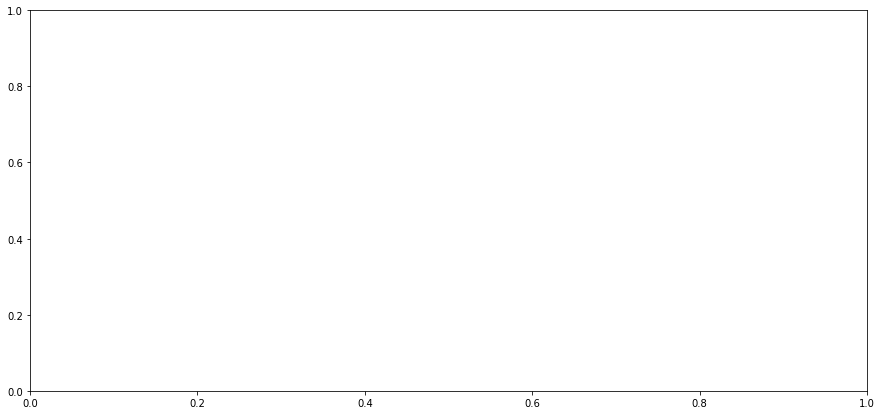

In [37]:
# if I had:


# I could graph:
fig, ax = plt.subplots(figsize=(15,7))
#data.plot(ax=ax)
ax.bar(data.index, data['count'])

#set ticks every week
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1))
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))